----
## Importing Dependencies

In [2]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [66]:
#modeling

from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

----
## Reading Datasets

In [7]:
training_df = pd.read_csv('/content/drive/MyDrive/DATA340-03_NLP/Emotions dataset for NLP with training+testing data/train.txt', names=['Text', 'Emotion'], sep=';')
val_df = pd.read_csv('/content/drive/MyDrive/DATA340-03_NLP/Emotions dataset for NLP with training+testing data/val.txt', names=['Text', 'Emotion'], sep=';')
test_df = pd.read_csv('/content/drive/MyDrive/DATA340-03_NLP/Emotions dataset for NLP with training+testing data/test.txt', names=['Text', 'Emotion'], sep=';')

In [8]:
training_df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [9]:
training_df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [10]:
val_df.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


----
## Exploratory Data Analysis


In [14]:
#check if the data is balanced or not
training_df.Emotion.value_counts()
training_df.Emotion.value_counts() / training_df.shape[0] *100

Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

In [15]:
test_df.Emotion.value_counts()
test_df.Emotion.value_counts() / test_df.shape[0] *100

Emotion
joy         34.75
sadness     29.05
anger       13.75
fear        11.20
love         7.95
surprise     3.30
Name: count, dtype: float64

In [16]:
val_df.Emotion.value_counts()
val_df.Emotion.value_counts() / val_df.shape[0] *100

Emotion
joy         35.20
sadness     27.50
anger       13.75
fear        10.60
love         8.90
surprise     4.05
Name: count, dtype: float64

In [17]:
# check for missing values
training_df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [18]:
test_df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [19]:
val_df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [20]:
# check for duplicate values
training_df.duplicated().sum()

1

In [21]:
test_df.duplicated().sum()

0

In [22]:
val_df.duplicated().sum()

0

In [23]:
#removing duplicated values
index = training_df[training_df.duplicated() == True].index
training_df.drop(index, axis = 0, inplace = True)
training_df.reset_index(inplace=True, drop = True)

In [24]:
# checking for duplicated text
training_df[training_df['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [25]:
#removing duplicated text for training dataset
index = training_df[training_df['Text'].duplicated() == True].index
training_df.drop(index, axis = 0, inplace = True)
training_df.reset_index(inplace=True, drop = True)

In [26]:
# checking for duplicated text
training_df[training_df['Text'].duplicated() == True]

,Text,Emotion


In [27]:
training_df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15964,i just had a very brief time in the beanbag an...,sadness
15965,i am now turning and i feel pathetic that i am...,sadness
15966,i feel strong and good overall,joy
15967,i feel like this was such a rude comment and i...,anger


In [28]:
training_df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15964,i just had a very brief time in the beanbag an...,sadness
15965,i am now turning and i feel pathetic that i am...,sadness
15966,i feel strong and good overall,joy
15967,i feel like this was such a rude comment and i...,anger


In [29]:
def clean_tokenize_text(the_text):
    #first convert the text to lowercases
    text = the_text.lower()
    #remove special characters and punctuation
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', the_text)
    #tokenize the text
    tokens = word_tokenize(cleaned_text.lower())
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    # this list comprehension helps identify the words that are non-stopwords and convert them to tokens
    tokens_filtered = [token for token in tokens if token not in stop_words]
    # lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_filtered]
    cleaned_string = ' '.join(tokens_lemmatized)
    return cleaned_string

In [30]:
# applying it to the dataframe

# making a new column called 'Cleaned_Text' that has cleaned and tokenized text
training_df['Cleaned_Text'] = training_df['Text'].apply(clean_tokenize_text)

test_df['Cleaned_Text'] = test_df['Text'].apply(clean_tokenize_text)
val_df['Cleaned_Text'] = val_df['Text'].apply(clean_tokenize_text)



In [31]:
training_df.head()

,Text,Emotion,Cleaned_Text
0,i didnt feel humiliated,sadness,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,feeling grouchy


In [32]:
test_df.head()

,Text,Emotion,Cleaned_Text
0,im feeling rather rotten so im not very ambiti...,sadness,im feeling rather rotten im ambitious right
1,im updating my blog because i feel shitty,sadness,im updating blog feel shitty
2,i never make her separate from me because i do...,sadness,never make separate ever want feel like ashamed
3,i left with my bouquet of red and yellow tulip...,joy,left bouquet red yellow tulip arm feeling slig...
4,i was feeling a little vain when i did this one,sadness,feeling little vain one


In [33]:
val_df.head()

,Text,Emotion,Cleaned_Text
0,im feeling quite sad and sorry for myself but ...,sadness,im feeling quite sad sorry ill snap soon
1,i feel like i am still looking at a blank canv...,sadness,feel like still looking blank canvas blank pie...
2,i feel like a faithful servant,love,feel like faithful servant
3,i am just feeling cranky and blue,anger,feeling cranky blue
4,i can have for a treat or if i am feeling festive,joy,treat feeling festive


----

## Data Visualization

### Training data

In [34]:
train_emotion_counts = training_df['Emotion'].value_counts() # to find the text frequency of each emotion

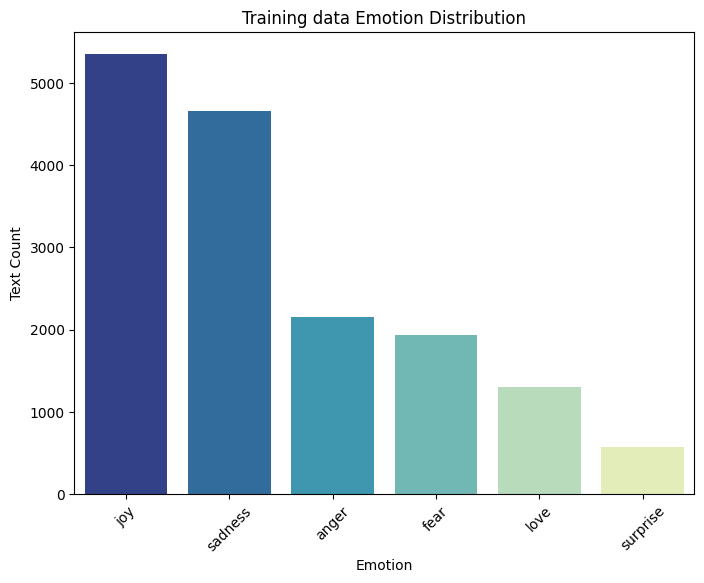

In [35]:
palette = sns.color_palette("YlGnBu_r", len(train_emotion_counts))
plt.figure(figsize=(8, 6))
sns.barplot(x=train_emotion_counts.index, y=train_emotion_counts.values, hue=train_emotion_counts.index, palette = palette, legend=False)
plt.title('Training data Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Text Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### Test data

In [36]:
test_emotion_counts = test_df['Emotion'].value_counts() # to find the text frequency of each emotion

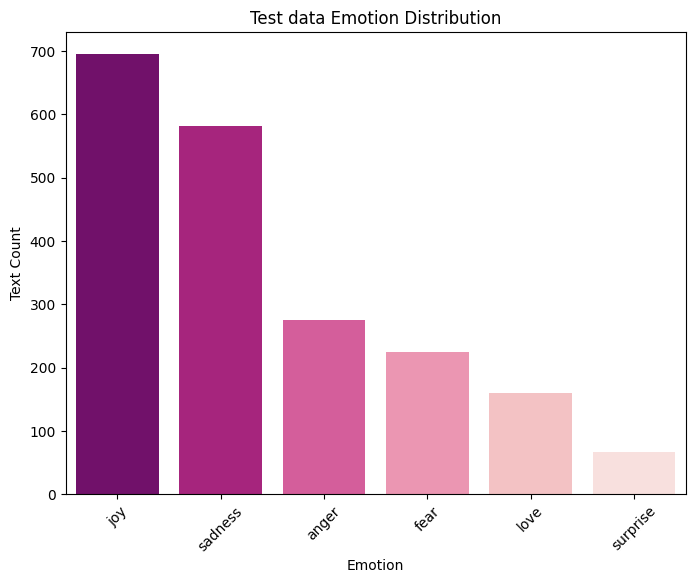

In [37]:
palette = sns.color_palette("RdPu_r", len(test_emotion_counts))
plt.figure(figsize=(8, 6))
sns.barplot(x=test_emotion_counts.index, y=test_emotion_counts.values, hue=test_emotion_counts.index, palette = palette, legend=False)
plt.title('Test data Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Text Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### Validation data

In [38]:
val_emotion_counts = val_df['Emotion'].value_counts() # to find the text frequency of each emotion

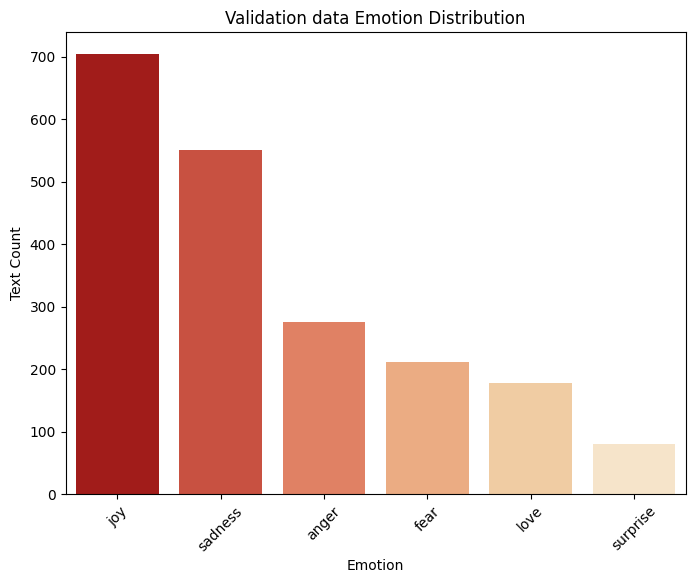

In [39]:
palette = sns.color_palette("OrRd_r", len(val_emotion_counts))
plt.figure(figsize=(8, 6))
sns.barplot(x=val_emotion_counts.index, y=val_emotion_counts.values, hue=val_emotion_counts.index, palette = palette, legend=False)
plt.title('Validation data Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Text Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()




In [40]:
# Calculate the length of each text entry (number of tokens)
training_df['Text_Length'] = training_df['Text'].apply(lambda x: len(x.split()))

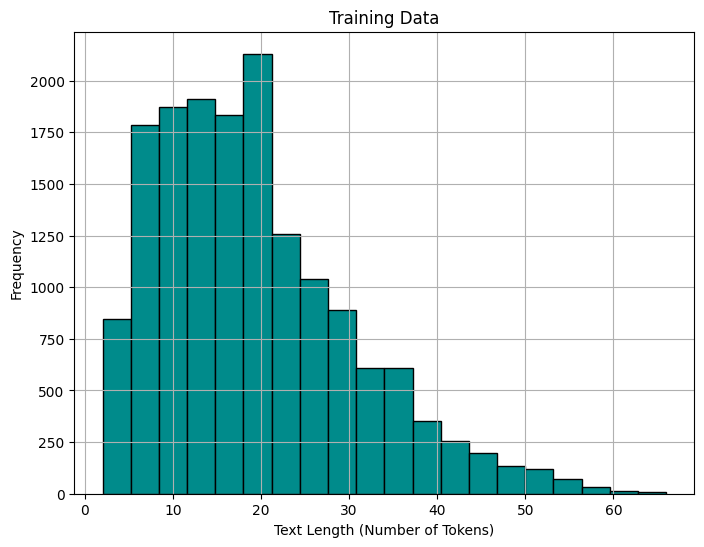

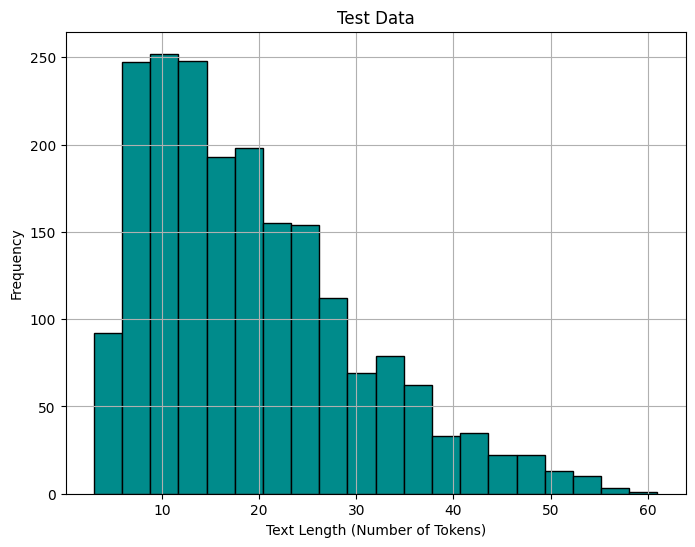

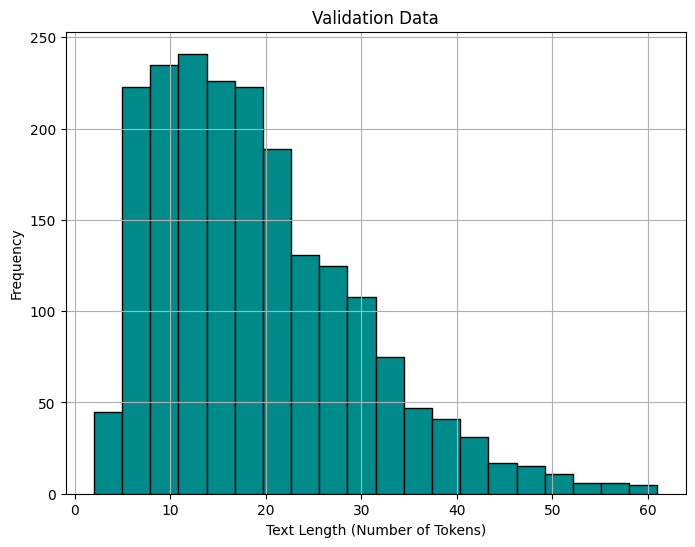

In [41]:
def plot_histogram(df, title):
    df['Text_Length'] = df['Text'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(8, 6))
    plt.hist(df['Text_Length'], bins=20, color='darkcyan', edgecolor='black')
    plt.title(title)  # Set the title to the parameter value
    plt.xlabel('Text Length (Number of Tokens)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

dataset_list = [("Training Data", training_df), ("Test Data", test_df), ("Validation Data", val_df)]

for title, dataset in dataset_list:
    plot_histogram(dataset, title)

## Word Cloud

In [42]:
!pip install wordcloud

In [43]:
from wordcloud import WordCloud
from pathlib import Path
import matplotlib as mpl

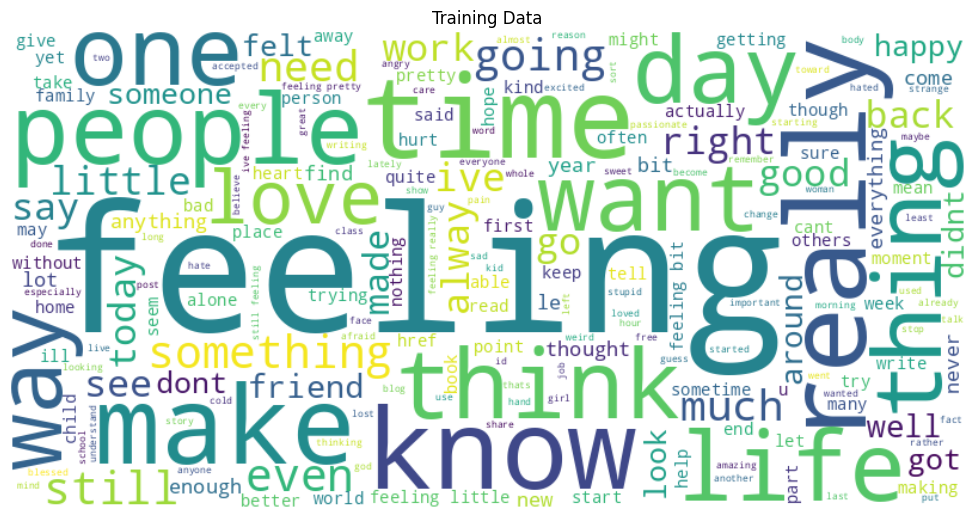

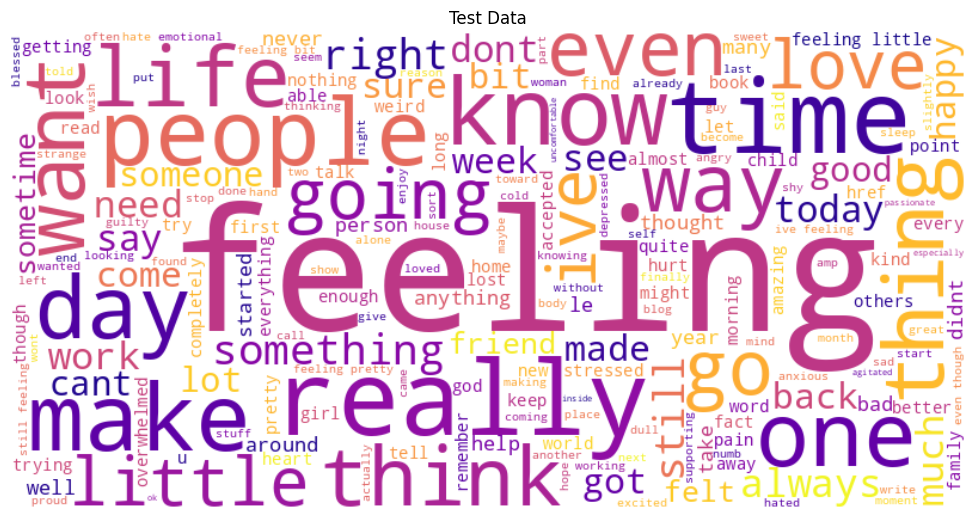

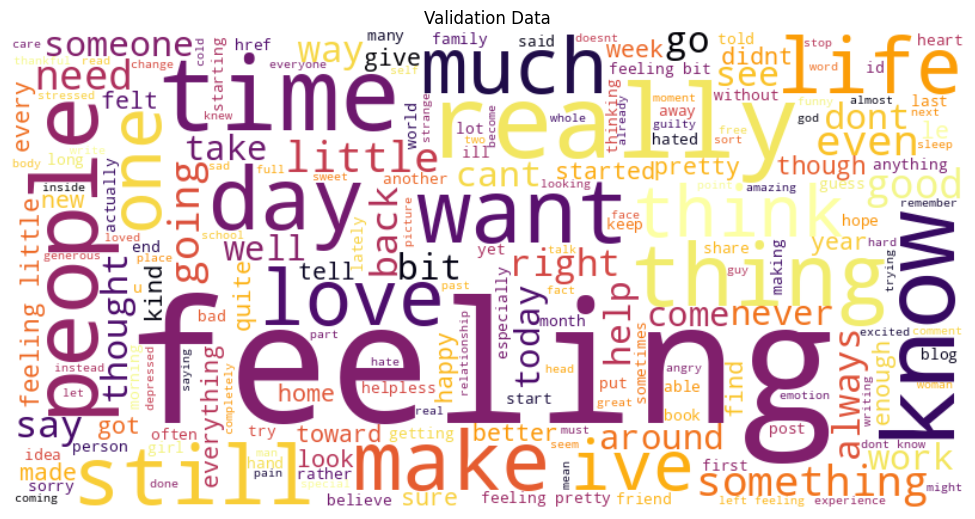

In [45]:
def generate_word_clouds(dataset_list):
    colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']  # List of colormaps for each dataset
    for i, (title, dataset) in enumerate(dataset_list):
        # Combine texts into a single string
        combined_text = ' '.join(dataset['Cleaned_Text'])

        # Additional words to exclude
        word_tokens = combined_text.split()
        additional_stop_words = {'feel', 'im'}

        # Filter out additional stop words
        filtered_text = [word for word in word_tokens if word.lower() not in additional_stop_words]
        filtered_text = ' '.join(filtered_text)

        # Generate word cloud with unique colormap
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormaps[i % len(colormaps)]).generate(filtered_text)

        # Display the word cloud using matplotlib
        plt.figure(figsize=(10, 5), facecolor=None)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title)
        plt.axis('off')  # Remove axis
        plt.tight_layout(pad=0)  # Adjust subplot parameters
        plt.show()

# Define your dataset list
dataset_list = [("Training Data", training_df), ("Test Data", test_df), ("Validation Data", val_df)]

# Call the function to generate word clouds
generate_word_clouds(dataset_list)

----
## Modeling using TF-IDF + Statistical Tests

In [46]:
#Preprocess text
X_train = training_df['Cleaned_Text'].values
y_train = training_df['Emotion'].values

X_test = test_df['Cleaned_Text'].values
y_test = test_df['Emotion'].values

X_val = val_df['Cleaned_Text'].values
y_val = val_df['Emotion'].values

In [47]:
def train_model(model, data, targets):
    # create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [48]:
def get_F1(trained_model,X,y):
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

In [49]:
#Using Logistic Regression

#Train the model with the training data
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=training_df.Emotion.unique(), columns=['F1 score'])


Accuracy:  0.869 



,F1 score
sadness,0.860377
anger,0.823810
love,0.893048
surprise,0.703704
fear,0.916456
joy,0.626263


In [50]:
#Using Decision Tree Classifier

#Train the model with the training data
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=DT.predict(X_test)

#calculate the accuracy
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=training_df.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8615 



,F1 score
sadness,0.872987
anger,0.812362
love,0.892779
surprise,0.753799
fear,0.898100
joy,0.600000


In [51]:
#Using SVM

#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=training_df.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.867 



,F1 score
sadness,0.857685
anger,0.827907
love,0.892905
surprise,0.681648
fear,0.914043
joy,0.654206


----
## Model Implementation for Sentiment Analysis

In [63]:
idx  = 4 # choosing example text from the dataset
print("Actual Text : ", X_test[idx])
print("Prediction : ", log_reg.predict(X_test)[idx])
print("Actual :     ", y_test[idx])

Actual Text :  feeling little vain one
Prediction :  sadness
Actual :      sadness


----

These results outline the accuracy performances of standard Python statistical models. Here, the best model is the logistic regression model, with an accuracy score of 86.9%, followed by the Support Vector model, 86.7%, and the Decision tree, 86.15%.

The F1 score is used to evaluate the performance of a classification model. It considers two metrics: Precision and Recall. Precision is the amount of accurate optimistic predictions among all positive predictions made by the model, and the Recall score measures the proportion of correct optimistic predictions among all actual positive instances in the data. The actual F1 score is computed from two times the product of the Precision and Recall score divided by the total added sum of Precision and Recall.

It ranges from 0 to 1, where 1 is perfect precision Precision, and 0 is poor performance. This score is vital in classification scenarios where class imbalance exists. By knowing the F1 score, we can determine the classification performance of the trained nlp model.


----
## Let's see if we can raise the acuracy score by using neural networks

In [ ]:
#Preprocess text
X_train = training_df['Cleaned_Text'].values
y_train = training_df['Emotion'].values

X_test = test_df['Cleaned_Text'].values
y_test = test_df['Emotion'].values

X_val = val_df['Cleaned_Text'].values
y_val = val_df['Emotion'].values

In [ ]:
y_val

array(['sadness', 'sadness', 'love', ..., 'joy', 'joy', 'joy'],
      dtype=object)

In [ ]:
y_train

array(['sadness', 'sadness', 'anger', ..., 'joy', 'anger', 'sadness'],
      dtype=object)

In [ ]:
y_test

array(['sadness', 'sadness', 'sadness', ..., 'joy', 'joy', 'fear'],
      dtype=object)

In [ ]:
# Encode labels so that the data is in numerical format for the machine learning algorithm to train on.
# Ohe is not necessary in this case as only a few levels of categorical variables need to be encoded.
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)


In [ ]:
#labels after encoding
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [ ]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [ ]:
X_train = pd.Series(X_train)
X_test = pd.Series(X_test)

In [ ]:
X_train

0                                    didnt feel humiliated
1        go feeling hopeless damned hopeful around some...
2                im grabbing minute post feel greedy wrong
3        ever feeling nostalgic fireplace know still pr...
4                                          feeling grouchy
                               ...                        
15964        brief time beanbag said anna feel like beaten
15965    turning feel pathetic still waiting table subb...
15966                             feel strong good overall
15967                       feel like rude comment im glad
15968                         know lot feel stupid portray
Length: 15969, dtype: object

In [ ]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [ ]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

17969

In [ ]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[53], [2], [531]]

In [ ]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

(3, 14323)

In [ ]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [ ]:
sequences_train # these are the sentences that are converted to indexes

[[53, 2, 531],
 [31, 3, 420, 3445, 434, 45, 56, 176, 1223],
 [5, 2719, 392, 147, 2, 354, 302],
 [74, 3, 586, 4092, 8, 20, 3446],
 [3, 994],
 [21, 3, 11, 435, 226, 227, 65],
 [21, 247, 7091, 6, 7092, 755, 21, 2451, 1312, 54, 1669, 41, 2, 4, 351],
 [2, 337, 18, 1313, 693, 44, 170, 277],
 [5084, 44, 2, 5084, 5085, 51, 46, 914, 3015],
 [2, 568],
 [2, 4, 10, 628, 451, 138, 25],
 [2, 355, 421, 252, 891, 647, 1765, 2452],
 [19, 5086, 6, 44, 2, 508],
 [2, 258, 346, 4093],
 [4094,
  1460,
  892,
  130,
  694,
  7093,
  937,
  87,
  68,
  6,
  127,
  1461,
  18,
  1462,
  3447,
  90,
  108,
  2453,
  3016,
  2,
  11,
  422],
 [2, 695, 915, 321],
 [53, 7, 2, 322],
 [2, 35, 495, 6],
 [92, 3, 827, 2454, 103, 475, 1870, 2103, 5087, 2454, 5088],
 [2, 3448, 796, 1123, 60, 3017, 40, 137],
 [2, 377, 436, 79, 149, 71, 278, 71],
 [3,
  174,
  134,
  124,
  2265,
  50,
  2,
  1871,
  2455,
  105,
  1596,
  1314,
  1035,
  119,
  115,
  557,
  965,
  15,
  637],
 [3, 828, 829],
 [97, 50, 5089, 5090, 452, 30

In [ ]:
# using padding to obtain vectors of equal lengths

In [ ]:
test_df.shape

(2000, 3)

In [ ]:
maxlen = max([len(t) for t in training_df['Cleaned_Text']])
maxlen

229

In [ ]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14323


## Word embedding

In [ ]:
vocabSize = len(tokenizer.index_word) + 1

In [ ]:
path_to_glove_file = '/content/drive/MyDrive/DATA340-03_NLP/Emotions dataset for NLP with training+testing data/glove.6B.200d.txt'

In [ ]:
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features

In [ ]:
embeddings_index = {}
with open(path_to_glove_file, encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs

# creating embedding matrix - assign word vectors to our dictionary/vocabulary to pass in neural network in embedding layer

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

The reasons why I chose to use GloVe word embeddings to capture semantic relationships between words in a corpus of text vary. One of the main reasons is that it efficiently detects relationships between words; it is trained using global word-word co-occurrence statistics from a corpus, directly optimizing word embeddings based on word occurring counts in the entire corpus. Word2Vec embeddings are trained using local context windows, which limits its prediction on non-popular words. Although this word embedding model is more computationally heavy, I prefer to use this on mental health data where it contains real-world instances of people's emotions.

## Building neural network architecture

In [ ]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))

model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))

model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))

model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 200)          2864600   
                                                                 
 bidirectional (Bidirection  (None, 229, 512)          935936    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 229, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [ ]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [ ]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=5,
                    callbacks=[callback]
                   )

Epoch 1/5
63/63 [==============================] - 2075s 32s/step - loss: 1.6123 - accuracy: 0.3204 - val_loss: 1.5862 - val_accuracy: 0.3520
Epoch 2/5
63/63 [==============================] - 2031s 32s/step - loss: 1.5778 - accuracy: 0.3328 - val_loss: 1.5858 - val_accuracy: 0.3520
Epoch 3/5
63/63 [==============================] - 2018s 32s/step - loss: 1.5782 - accuracy: 0.3287 - val_loss: 1.5825 - val_accuracy: 0.3520
Epoch 4/5
63/63 [==============================] - 2013s 32s/step - loss: 1.5765 - accuracy: 0.3329 - val_loss: 1.5903 - val_accuracy: 0.2750
Epoch 5/5
63/63 [==============================] - 2008s 32s/step - loss: 1.5779 - accuracy: 0.3317 - val_loss: 1.5791 - val_accuracy: 0.3520


In [ ]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 107s 2s/step - loss: 1.5791 - accuracy: 0.3520


[1.579084873199463, 0.35199999809265137]

In [ ]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 110s 2s/step - loss: 1.5593 - accuracy: 0.3475


[1.5592682361602783, 0.3474999964237213]

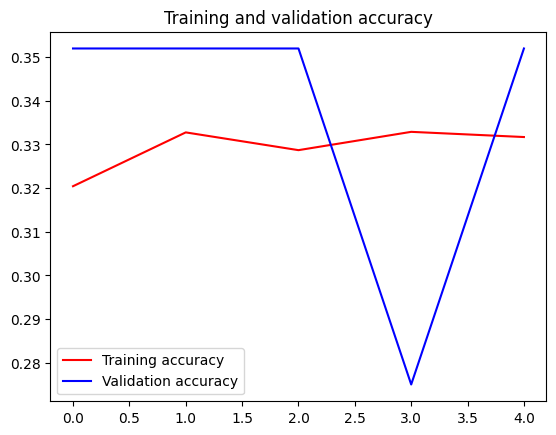

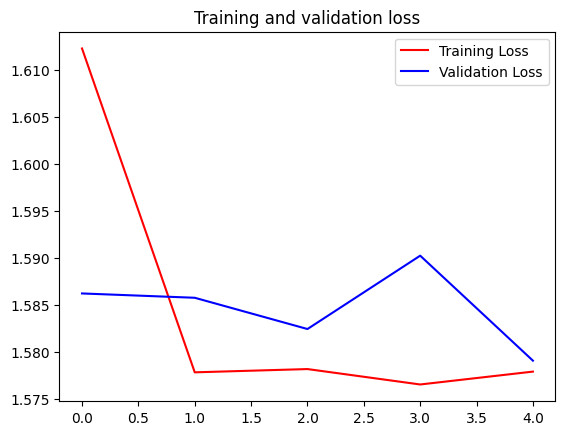

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# these charts does not show a very acurate model

----
## Model architecture explanation

The model architecture code block shows the code composition required to build a neural network for this project.

The embedding layer converts input sequences that are represented as integers in dense vectors of fixed size.

This neural network is fortified with three bidirectional LSTM layers. The first two LSTM layers, by returning sequences as a single output for each sequence, play a pivotal role in capturing long-range dependencies and contextual information from input sequences, a function that is essential for the success of our model.

Lastly, the dense layer is added to produce the final output. There are six output classes, and 'softmax' helps ensure that the output values are probabilities summing up to 1 across all classes.

Explanation of hyperparameter choices:

- Embedding Dimension is 200 and determines the size of the dense embedding vectors representing each word in vocabulary. A large embedding dimension allows the model to capture more nuanced semantic relationships between words.
Here, it is large enough to provide a balanced between model expressiveness and computational efficiency.

- LSTM unit of 256 and 128 determine the complexity and capacity of the LSTM layers to learn complex patterns from input sequences. Increases computational cost and risk of overfitting.

- Dropout rate of 0.2 to prevent overfitting, 20% of the input units will be randomly set to zero during each training iteration.

- Recurrent Dropout Rate of 0.2 also prevents overfitting and is consistent with the dropout rate for input units.

- Softmax activation function is used in the output layer that transforms output logits into  probabilities, and each  output represents the probability of a particular class.

In [ ]:
model.save('text_emotion_recognition.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


----
## Results

The best model may not be the most complex model, in this case, the LSTM did not outperform the other models, and it also had an accuracy score way lower than the other statistical models; it had an accuracy score of 35%. An inference that I can make for the reason why the accuracy score is so low for the LSTM model is because of its hyperparameters and time I spent on the experimental training aspect of this model.